# Predicting and Preventing Customer Churn: Modeling

*In this notebook I take an iterative approach to modeling. If you're reading this and are only really interested in the final model then skip down towards the bottom the the section labeled 'Final Model'

In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
np.random.RandomState(seed=42)

RandomState(MT19937) at 0x131EEC8D0

In [431]:
df= pd.read_csv('Telecom_Churn.csv', index_col= 0)
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,145.805,0


### Before doing any modeling we want to look at our baseline churn rate. This will be relevant when looking at accurcy scores

In [432]:
total= len(df)
churn= df.Churn.value_counts()

print('{}% did not churn.'.format(round(churn[0]/total * 100)))
print('{}% churned. This is our annual churn rate which is very important!!'.format(round(churn[1]/total * 100)))

84% did not churn.
16% churned. This is our annual churn rate which is very important!!


In [433]:
print('Non-Churn Count: {}'.format(churn[0]))
print('Chrun Count: {}'.format(churn[1]))

Non-Churn Count: 2655
Chrun Count: 495


### Splitting Data into Train and Test

In [434]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X= df.drop(columns='Churn')
y= df['Churn'].values
x_train, x_test, y_train, y_test= train_test_split(X, y, test_size=0.3, stratify=y)

scaler= StandardScaler()
x_train_scaled= scaler.fit_transform(x_train)
x_test_scaled= scaler.fit_transform(x_test)

## Baseline Model: Logistic Regression Out of Box 

In [435]:
# Create a dataframe to hold summary of all model iteration perforamances
model_performance=pd.DataFrame(columns=['Model Type', 'Avg Accuracy', 'Churn Class Precision', 'Churn Class Recall', 'Churn Class F1-Score'])
model_performance

,Model Type,Avg Accuracy,Churn Class Precision,Churn Class Recall,Churn Class F1-Score


In [436]:
# Make sure our X-variables are correct
print('Our X variables are {}.'.format(X.columns))
print('\n')
# Make sure the shape of our test and train arrays looks correct
print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

Our X variables are Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status',
       'Customer Value'],
      dtype='object').


(2205, 12)
(945, 12)
(2205,)
(945,)


In [437]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
model_name= 'Logistic Regression'
# create model variables
model= LogisticRegression()
# fit the model
result= model.fit(x_train_scaled, y_train)
# make predictions
y_pred= model.predict(x_test_scaled)

# computer average score
avg_score= round(metrics.accuracy_score(y_test, y_pred),2)

# compute classification report
report= metrics.classification_report(y_test, y_pred)
print('Classification Report for {} Model'.format(model_name))
print(report)

# get classification report as dict
report_dict= metrics.classification_report(y_test, y_pred, output_dict=True)
# get only metrics for churn class
report_churn= list(m1_dict['1'].values())
# pull out individual churn metrics
churn_precision= round(report_churn[0],2)
churn_recall= round(report_churn[1], 2)
churn_f1= round(report_churn[2], 2)

# add model metrics to the data frame
new_row={'Model Type': model_name, 'Avg Accuracy': avg_score, 'Churn Class Precision': churn_precision, 
         'Churn Class Recall': churn_recall, 'Churn Class F1-Score': churn_f1}
model_performance= model_performance.append(new_row, ignore_index=True)


Classification Report for Logistic Regression Model
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       797
           1       0.76      0.45      0.57       148

    accuracy                           0.89       945
   macro avg       0.83      0.71      0.75       945
weighted avg       0.88      0.89      0.88       945



In [438]:
model_performance

,Model Type,Avg Accuracy,Churn Class Precision,Churn Class Recall,Churn Class F1-Score
0,Logistic Regression,0.89,0.75,0.49,0.6


## Identifying the Factors that Contribute to Churn

In [457]:
coefficients= result.coef_.tolist()
features= list(x_train.columns)

# Visualizing Feature Importance from the Random Forest
# create empty df
logit_df= pd.DataFrame()
# create list of feature importances
#importances= result.feature_importances_
#create list to hold the feature names
#features= list(x_train.columns)
coefficients= result.coef_.tolist()[0]
features= list(x_train.columns)


# Add features and their importance to the dataframe
logit_df['Feature']= features
logit_df['Importance']= coefficients

logit_df

,Feature,Importance
0,Call Failure,0.858119
1,Complains,1.066359
2,Subscription Length,-0.230408
3,Charge Amount,-0.638606
4,Seconds of Use,0.753244
5,Frequency of use,-2.153761
6,Frequency of SMS,-1.261821
7,Distinct Called Numbers,-0.217641
8,Age Group,-0.019849
9,Tariff Plan,-0.081694


## Modeling for Ensemble Methods without balancing classing

In [407]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN
models= [RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier()]

# Loop through model types and build a model for each model type while adding performance metrics to model_performance df
for model in models:
    model_name= str(model)[:-2]
    # create model variables
    model= model
    # fit the model
    result= model.fit(x_train, y_train)
    # make predictions
    y_pred= model.predict(x_test)

    # computer average score
    avg_score= round(metrics.accuracy_score(y_test, y_pred),2)

    # compute classification report
    report= metrics.classification_report(y_test, y_pred)
    print('Classification Report for {} Model'.format(model_name))
    print(report)

    # get classification report as dict
    report_dict= metrics.classification_report(y_test, y_pred, output_dict=True)
    # get only metrics for churn class
    report_churn= list(report_dict['1'].values())
    # pull out individual churn metrics
    churn_precision= round(report_churn[0],2)
    churn_recall= round(report_churn[1], 2)
    churn_f1= round(report_churn[2], 2)

    # add model metrics to the data frame
    new_row={'Model Type': model_name, 'Avg Accuracy': avg_score, 'Churn Class Precision': churn_precision, 
             'Churn Class Recall': churn_recall, 'Churn Class F1-Score': churn_f1}
    model_performance= model_performance.append(new_row, ignore_index=True)

Classification Report for RandomForestClassifier Model
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       796
           1       0.90      0.77      0.83       149

    accuracy                           0.95       945
   macro avg       0.93      0.87      0.90       945
weighted avg       0.95      0.95      0.95       945

Classification Report for GradientBoostingClassifier Model
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       796
           1       0.88      0.66      0.75       149

    accuracy                           0.93       945
   macro avg       0.91      0.82      0.86       945
weighted avg       0.93      0.93      0.93       945

Classification Report for AdaBoostClassifier Model
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       796
           1       0.80      0.70      0.75       149

    accuracy     

In [408]:
model_performance

,Model Type,Avg Accuracy,Churn Class Precision,Churn Class Recall,Churn Class F1-Score
0,Logistic Regression,0.89,0.75,0.49,0.60
1,RandomForestClassifier,0.95,0.90,0.77,0.83
2,GradientBoostingClassifier,0.93,0.88,0.66,0.75
3,AdaBoostClassifier,0.93,0.80,0.70,0.75


## Modeling for Ensemble Methods using various SMOTE and ADASYN Ratios to Oversample the Minority Class

In [409]:
ratios= [0.25, 0.5, 0.75, 'auto']
oversample_techniques= [SMOTE, ADASYN]

# Loop through model types
for model in models:
    # For each model type build a model using each over sampling technique
    for technique in oversample_techniques:
        # for each over sampling technique build a model using each different sampling ratio
        for ratio in ratios:
            model_name= '{} with {} {}'.format(str(model)[:-2], str(technique).split('.')[3], ratio)
            sample_method= technique(sampling_strategy=ratio)
            x_train_smote, y_train_smote= sm.fit_sample(x_train, y_train)
            # establish model
            model= model
            # fit model
            result= model.fit(x_train_smote, y_train_smote)
            # make predictions
            y_pred= model.predict(x_test)

            # computer average score
            avg_score= round(metrics.accuracy_score(y_test, y_pred),2)

            # compute classification report
            report= metrics.classification_report(y_test, y_pred)
            print('Classification Report for {} Model'.format(model_name))
            print(report)

            # get classification report as dict
            report_dict= metrics.classification_report(y_test, y_pred, output_dict=True)
            # get only metrics for churn class
            report_churn= list(report_dict['1'].values())
            # pull out individual churn metrics
            churn_precision= round(report_churn[0],2)
            churn_recall= round(report_churn[1], 2)
            churn_f1= round(report_churn[2], 2)

            # add model metrics to the data frame
            new_row={'Model Type': model_name, 'Avg Accuracy': avg_score, 'Churn Class Precision': churn_precision, 
                     'Churn Class Recall': churn_recall, 'Churn Class F1-Score': churn_f1}
            model_performance= model_performance.append(new_row, ignore_index=True)
               
        

Classification Report for RandomForestClassifier with SMOTE'> 0.25 Model
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       796
           1       0.80      0.93      0.86       149

    accuracy                           0.95       945
   macro avg       0.89      0.94      0.91       945
weighted avg       0.96      0.95      0.95       945

Classification Report for RandomForestClassifier with SMOTE'> 0.5 Model
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       796
           1       0.80      0.91      0.86       149

    accuracy                           0.95       945
   macro avg       0.89      0.94      0.91       945
weighted avg       0.96      0.95      0.95       945

Classification Report for RandomForestClassifier with SMOTE'> 0.75 Model
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       796
           1       

Classification Report for AdaBoostClassifier with ADASYN'> 0.5 Model
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       796
           1       0.54      0.93      0.68       149

    accuracy                           0.86       945
   macro avg       0.76      0.89      0.80       945
weighted avg       0.91      0.86      0.88       945

Classification Report for AdaBoostClassifier with ADASYN'> 0.75 Model
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       796
           1       0.54      0.93      0.68       149

    accuracy                           0.86       945
   macro avg       0.76      0.89      0.80       945
weighted avg       0.91      0.86      0.88       945

Classification Report for AdaBoostClassifier with ADASYN'> auto Model
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       796
           1       0.54     

In [410]:
model_performance

,Model Type,Avg Accuracy,Churn Class Precision,Churn Class Recall,Churn Class F1-Score
0,Logistic Regression,0.89,0.75,0.49,0.60
1,RandomForestClassifier,0.95,0.90,0.77,0.83
2,GradientBoostingClassifier,0.93,0.88,0.66,0.75
3,AdaBoostClassifier,0.93,0.80,0.70,0.75
4,RandomForestClassifier with SMOTE'> 0.25,0.95,0.80,0.93,0.86
5,RandomForestClassifier with SMOTE'> 0.5,0.95,0.80,0.91,0.86
6,RandomForestClassifier with SMOTE'> 0.75,0.95,0.80,0.91,0.85
7,RandomForestClassifier with SMOTE'> auto,0.95,0.80,0.91,0.85
8,RandomForestClassifier with ADASYN'> 0.25,0.95,0.80,0.91,0.86
9,RandomForestClassifier with ADASYN'> 0.5,0.95,0.79,0.92,0.85


## Logistic Regression with SMOTE

In [411]:
# Since are using Logistic Regression we need to apply SMOTE to our scaled x training data 
# assign smote variable
sm = SMOTE(random_state=12)
# apply smote to our x_train and y_train 
x_train_scaled_smote, y_train_smote = sm.fit_sample(x_train_scaled, y_train)
# Check to see what the class balance looks like now 
print (np.unique(y_train, return_counts=True) , np.bincount(y_train_smote))
print('\n')

model_name= 'Logistic Regression with SMOTE'
# establish model
model= LogisticRegression()
# fit model
result= model.fit(x_train_scaled_smote, y_train_smote)
# make predictions
y_pred= model.predict(x_test_scaled)

# computer average score
avg_score= round(metrics.accuracy_score(y_test, y_pred),2)

# compute classification report
report= metrics.classification_report(y_test, y_pred)
print('Classification Report for {} Model'.format(model_name))
print(report)

# get classification report as dict
report_dict= metrics.classification_report(y_test, y_pred, output_dict=True)
# get only metrics for churn class
report_churn= list(report_dict['1'].values())
# pull out individual churn metrics
churn_precision= round(report_churn[0],2)
churn_recall= round(report_churn[1], 2)
churn_f1= round(report_churn[2], 2)

# add model metrics to the data frame
new_row={'Model Type': model_name, 'Avg Accuracy': avg_score, 'Churn Class Precision': churn_precision, 
         'Churn Class Recall': churn_recall, 'Churn Class F1-Score': churn_f1}
model_performance= model_performance.append(new_row, ignore_index=True)

model_performance

(array([0, 1]), array([1859,  346])) [1859 1859]


Classification Report for Logistic Regression with SMOTE Model
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       796
           1       0.52      0.89      0.66       149

    accuracy                           0.85       945
   macro avg       0.75      0.87      0.78       945
weighted avg       0.90      0.85      0.87       945



,Model Type,Avg Accuracy,Churn Class Precision,Churn Class Recall,Churn Class F1-Score
0,Logistic Regression,0.89,0.75,0.49,0.60
1,RandomForestClassifier,0.95,0.90,0.77,0.83
2,GradientBoostingClassifier,0.93,0.88,0.66,0.75
3,AdaBoostClassifier,0.93,0.80,0.70,0.75
4,RandomForestClassifier with SMOTE'> 0.25,0.95,0.80,0.93,0.86
5,RandomForestClassifier with SMOTE'> 0.5,0.95,0.80,0.91,0.86
6,RandomForestClassifier with SMOTE'> 0.75,0.95,0.80,0.91,0.85
7,RandomForestClassifier with SMOTE'> auto,0.95,0.80,0.91,0.85
8,RandomForestClassifier with ADASYN'> 0.25,0.95,0.80,0.91,0.86
9,RandomForestClassifier with ADASYN'> 0.5,0.95,0.79,0.92,0.85


In [412]:
# Let's take a look at our top five performing models by F1 Score
model_performance.sort_values(by='Churn Class F1-Score', ascending=False).head(5)

,Model Type,Avg Accuracy,Churn Class Precision,Churn Class Recall,Churn Class F1-Score
4,RandomForestClassifier with SMOTE'> 0.25,0.95,0.8,0.93,0.86
5,RandomForestClassifier with SMOTE'> 0.5,0.95,0.8,0.91,0.86
8,RandomForestClassifier with ADASYN'> 0.25,0.95,0.8,0.91,0.86
6,RandomForestClassifier with SMOTE'> 0.75,0.95,0.8,0.91,0.85
7,RandomForestClassifier with SMOTE'> auto,0.95,0.8,0.91,0.85


### Notes

#### Random Forest seems to be our best model type. Which method of over sampling the minority class is best is not quite as clear.

## What if we do some further feature engineering? 

### Does clustering our continous variables before modeling improve performance? 

In [413]:
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,145.805,0


In [414]:
df.columns

Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status',
       'Customer Value', 'Churn'],
      dtype='object')

Elbow Method for Call  Failure


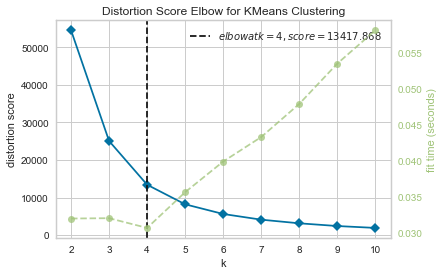



Elbow Method for Subscription  Length


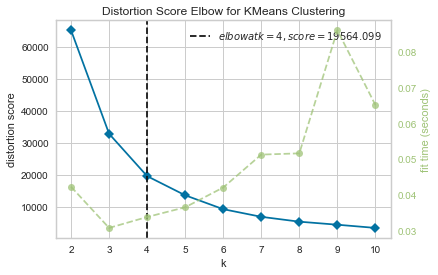



Elbow Method for Seconds of Use


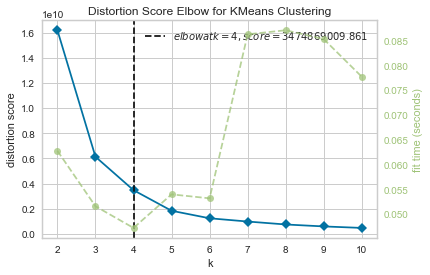



Elbow Method for Frequency of use


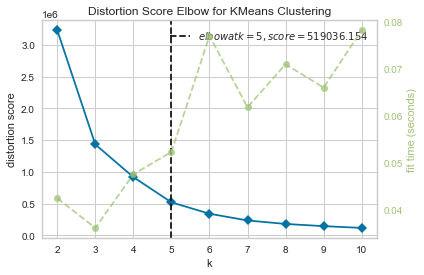



Elbow Method for Frequency of SMS


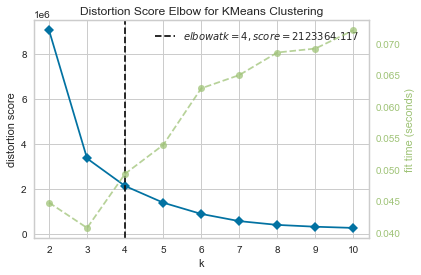



Elbow Method for Distinct Called Numbers


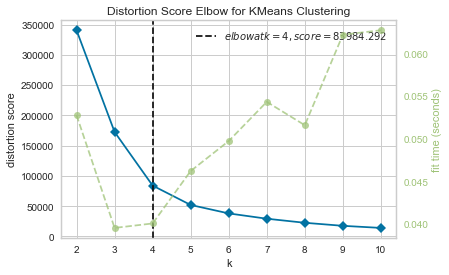



Elbow Method for Customer Value


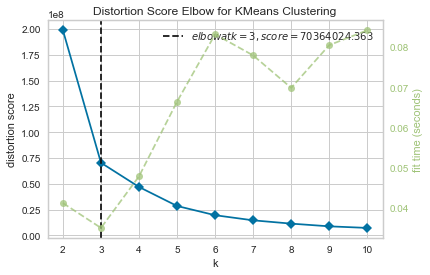

In [415]:
# We could try using KNN to group categorical variables
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
# Establish list of continuous variables
cont_vars= ['Call  Failure','Subscription  Length',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers',
       'Customer Value']

# Loop through continous variables and create and elbow chart for each
for x in cont_vars:
    var= df[x].values.reshape((-1,1))
    model = KElbowVisualizer(KMeans(), k=10)
    model.fit(var)
    print('Elbow Method for {}'.format(x))
    model.show()
    print('\n')


In [416]:
# Best Ks are Call fail: 4, Subscription Length: 4, Seconds of Use: 4, Frequency of Use: 5, Frequency of SMS: 4, 
# Distinct called numbers: 4, Customer Lifetime Value: 3
#create a copy of the dataset to hold the clustered continous variables
df_clustered= df.copy()
# list of the best Ks
best_k=[4,4,4,5,4,4,3]
#match the best Ks with their appropriate column name
combo_list= list(zip(cont_vars, best_k))

# Loop through the combined list 
for x, y in combo_list:
    # establish the var to be clustered
    var=df[x].values.reshape((-1,1))
    # fit the model using the appropriate number of clusters
    model= KMeans(n_clusters=y)
    model.fit(var)
    labels= model.labels_
    # assign the labels to the df_cluster in place of the continous values
    df_clustered[x]= labels

# check to make sure the number of unique values in the df_clustered matchs up with the best ks
check=[]
for x in cont_vars:
    num= df_clustered[x].nunique()
    check.append(num)

print(best_k)
print(check)
    


[4, 4, 4, 5, 4, 4, 3]
[4, 4, 4, 5, 4, 4, 3]


### Random Forest with Clustered Continuous Variables

In [417]:
# X will be all attributes except churn
X= df_clustered.drop(columns= 'Churn')
# y will be churn values
y= df_clustered['Churn'].values

x_train_cluster, x_test_cluster, y_train_cluster, y_test_cluster= train_test_split(X, y, test_size=0.3, stratify=y)

model_name= 'Random Forest w/ Clustered Continuous Vars'
# create model variables
model= RandomForestClassifier()
# fit the model
result= model.fit(x_train_cluster, y_train_cluster)
# make predictions
y_pred= model.predict(x_test_cluster)

# computer average score
avg_score= round(metrics.accuracy_score(y_test_cluster, y_pred),2)

# compute classification report
report= metrics.classification_report(y_test_cluster, y_pred)
print('Classification Report for {} Model'.format(model_name))
print(report)

# get classification report as dict
report_dict= metrics.classification_report(y_test_cluster, y_pred, output_dict=True)
# get only metrics for churn class
report_churn= list(report_dict['1'].values())
# pull out individual churn metrics
churn_precision= round(report_churn[0],2)
churn_recall= round(report_churn[1], 2)
churn_f1= round(report_churn[2], 2)

# add model metrics to the data frame
new_row={'Model Type': model_name, 'Avg Accuracy': avg_score, 'Churn Class Precision': churn_precision, 
         'Churn Class Recall': churn_recall, 'Churn Class F1-Score': churn_f1}
model_performance= model_performance.append(new_row, ignore_index=True)

Classification Report for Random Forest w/ Clustered Continuous Vars Model
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       797
           1       0.82      0.72      0.77       148

    accuracy                           0.93       945
   macro avg       0.89      0.84      0.86       945
weighted avg       0.93      0.93      0.93       945



### Logistic Regression with Clustered Continuous Variables

In [418]:
# We need to scale our X variables
x_train_cluster_scaled= scaler.fit_transform(x_train_cluster)
x_test_cluster_scaled= scaler.fit_transform(x_test_cluster)
model_name= 'Logistic Regression w/ Clustered Continuous Vars'
# create model variables
model= LogisticRegression()
# fit the model
result= model.fit(x_train_cluster_scaled, y_train_cluster)
# make predictions
y_pred= model.predict(x_test_cluster_scaled)

# computer average score
avg_score= round(metrics.accuracy_score(y_test_cluster, y_pred),2)

# compute classification report
report= metrics.classification_report(y_test_cluster, y_pred)
print('Classification Report for {} Model'.format(model_name))
print(report)

# get classification report as dict
report_dict= metrics.classification_report(y_test_cluster, y_pred, output_dict=True)
# get only metrics for churn class
report_churn= list(m1_dict['1'].values())
# pull out individual churn metrics
churn_precision= round(report_churn[0],2)
churn_recall= round(report_churn[1], 2)
churn_f1= round(report_churn[2], 2)

# add model metrics to the data frame
new_row={'Model Type': model_name, 'Avg Accuracy': avg_score, 'Churn Class Precision': churn_precision, 
         'Churn Class Recall': churn_recall, 'Churn Class F1-Score': churn_f1}
model_performance= model_performance.append(new_row, ignore_index=True)

Classification Report for Logistic Regression w/ Clustered Continuous Vars Model
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       797
           1       0.84      0.40      0.54       148

    accuracy                           0.89       945
   macro avg       0.87      0.69      0.74       945
weighted avg       0.89      0.89      0.88       945



### Notes

Clustering the categorical variables did not help our performance at all. In fact, it hurt performance. So I won't continue further down that path.

## Selecting a Final Model

In [419]:
# Let's take a look at our top 5 models
model_performance.sort_values(by='Churn Class F1-Score', ascending=False).head()

,Model Type,Avg Accuracy,Churn Class Precision,Churn Class Recall,Churn Class F1-Score
4,RandomForestClassifier with SMOTE'> 0.25,0.95,0.8,0.93,0.86
5,RandomForestClassifier with SMOTE'> 0.5,0.95,0.8,0.91,0.86
8,RandomForestClassifier with ADASYN'> 0.25,0.95,0.8,0.91,0.86
6,RandomForestClassifier with SMOTE'> 0.75,0.95,0.8,0.91,0.85
7,RandomForestClassifier with SMOTE'> auto,0.95,0.8,0.91,0.85


### Our top 5 models are fairly comparable but we are going to go with Random Forest with SMOTE Ratio at 0.5 as it has one of the best F1 scores and recall is high meaning we are catching a lot of the true Churn cases

In [420]:
# Lets Recompute the Model (result may be slight different due to the random elements)
# Create SMOTE variable with a sampling strategy of 0.5
sm = SMOTE(sampling_strategy=0.5, random_state=12)
# apply smote to our x_train and y_train 
x_train_smote, y_train_smote = sm.fit_sample(x_train, y_train)
# Check to see what the class balance looks like now 
print (np.unique(y_train, return_counts=True) , np.bincount(y_train_smote))
print('\n')

model_name= 'FINAL MODEL: Random Forest with 0.5 SMOTE Ratio'
# create model variables
model= RandomForestClassifier()
# fit the model
result= model.fit(x_train_smote, y_train_smote)
# make predictions
y_pred= model.predict(x_test)

# computer average score
avg_score= round(metrics.accuracy_score(y_test, y_pred),2)

# compute classification report
report= metrics.classification_report(y_test, y_pred)
print('Classification Report for {} Model'.format(model_name))
print(report)

(array([0, 1]), array([1859,  346])) [1859  929]


Classification Report for FINAL MODEL: Random Forest with 0.5 SMOTE Ratio Model
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       796
           1       0.86      0.89      0.88       149

    accuracy                           0.96       945
   macro avg       0.92      0.93      0.93       945
weighted avg       0.96      0.96      0.96       945



Text(0, 0.5, 'Feature')

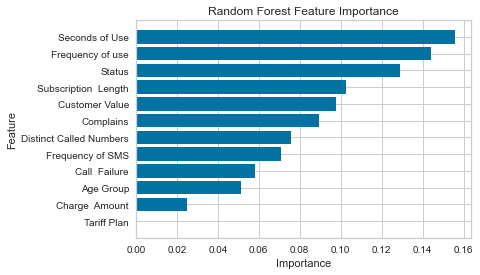

In [421]:
# Visualizing Feature Importance from the Random Forest
# create empty df
impt_df= pd.DataFrame()
# create list of feature importances
importances= result.feature_importances_
#create list to hold the feature names
features= list(x_train.columns)

# Add features and their importance to the dataframe
impt_df['Feature']= features
impt_df['Importance']= importances

# Plot the sorted feature importances
impt_df= impt_df.sort_values(by='Importance')
plt.barh(y=impt_df.Feature, width=impt_df.Importance)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')


In [422]:
# Predict the probabilities from model and covert to a list 
proba= result.predict_proba(x_test)
proba_list=proba.tolist()

# The probability of churn is the second value in each nested loop so we want to loop through and pull that
# value out into it's own list
churn_prob=[]
for item in proba_list:
    churn_prob.append(item[1])

# create a df that is copy of x_test
df_prob= x_test.copy()

# add our churn prediction and the subsequent probability of churn to the df
df_prob['Churn Prediction']= y_pred
df_prob['Churn Probability']= churn_prob

df_prob.tail(10)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Customer Value,Churn Prediction,Churn Probability
1899,0,0,12,1,1182,19,1,6,3,1,1,52.040,1,0.690000
1901,1,0,38,0,723,10,8,2,2,1,2,68.985,1,0.690000
843,4,0,30,1,3225,67,16,24,3,1,1,195.680,0,0.020000
2348,6,0,7,1,4615,44,212,8,3,1,1,1034.360,0,0.000000
2236,5,0,35,0,1910,47,40,20,3,1,2,238.280,0,0.180000
1697,3,0,13,1,2433,33,0,13,3,1,1,98.640,0,0.210000
1441,0,0,27,0,700,12,25,6,4,1,2,80.300,0,0.153833
693,4,0,25,0,3415,62,17,26,3,1,1,207.080,0,0.030000
1541,0,0,24,0,1120,14,35,16,4,1,2,115.850,0,0.131667
1560,0,0,36,0,5013,79,0,13,2,1,1,229.140,0,0.270000


In [423]:
# Ideally we want to intervene when we have high value customers who are at risk of churns
# Here we will pull out just those cutomers
# Etablish a reference point for above average value customers
median_value= df_prob['Customer Value'].median()
# Establish a point for what it means to be at high risk of churning
high_prob= 0.65

# Create a df of just those who are of above avergae value and are at high risk of churning
high_risk_df= df_prob[(df_prob['Customer Value'] >= median_value) & (df_prob['Churn Probability'] > high_prob)].sort_values(by='Customer Value', ascending=False)
high_risk_df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Customer Value,Churn Prediction,Churn Probability
688,6,1,27,1,1505,37,202,14,2,2,1,978.390,1,0.81
1624,8,1,35,1,5628,98,51,26,2,1,1,487.170,1,0.72
24,13,1,36,1,5818,98,26,24,2,1,1,383.220,1,0.99
2524,16,0,35,2,5943,96,22,21,2,1,1,370.755,1,0.67
1124,11,1,36,1,5573,95,24,24,2,1,1,363.060,1,0.95
124,10,0,34,0,5758,95,21,22,2,1,1,357.885,1,0.98
2424,13,0,32,1,5863,94,18,20,2,1,1,349.065,1,0.93
2074,8,0,34,0,5513,92,19,22,2,1,1,337.725,1,0.95
2024,8,0,34,0,5513,92,19,22,2,1,1,337.725,1,0.95
1074,8,1,34,0,5513,92,19,22,2,1,1,337.725,1,0.97
